In [1]:
import jax
import jax.numpy as jnp

In [2]:
x = jnp.arange(10)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
x

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [4]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

5.56 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [7]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [8]:
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [9]:
import numpy as np

In [14]:
x = np.array([1,2,3])

In [19]:
def in_place_modify(x):
    # x[0] = 123
    xnew = x
    xnew[0] = 123
    return xnew

In [12]:
in_place_modify(x)

In [13]:
x

array([123,   2,   3])

In [21]:
def jax_in_place_modify(x):
    return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

Array([123,   2,   3], dtype=int32)

In [22]:
y

Array([1, 2, 3], dtype=int32)

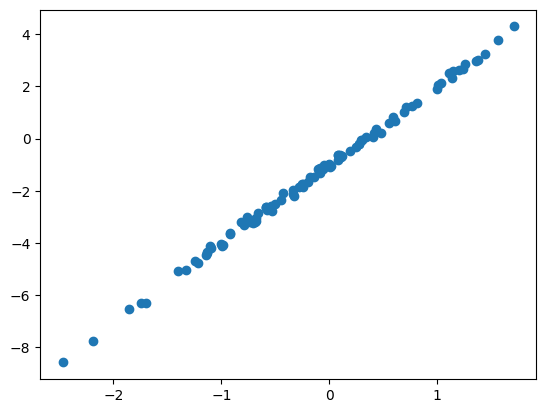

In [23]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [24]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [25]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [26]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.01, b: -1.00


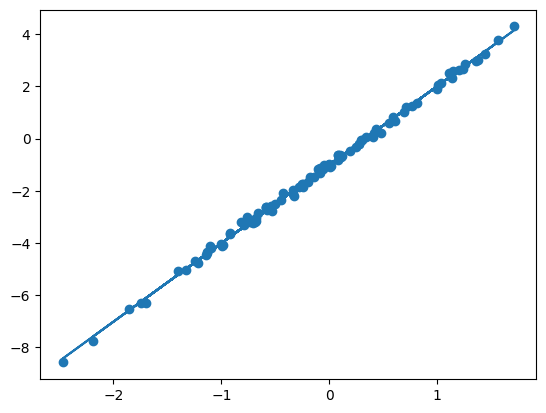

In [27]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

In [28]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [29]:
def log2_with_print(x):
  print("printed x:", x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.))

printed x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [30]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


In [31]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

2.25 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
selu_jit = jax.jit(selu)

# Warm up
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

331 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
# Condition on value of x.

def f(x):
    if x > 1:
        return x
    else:
        return 2 * x

# f_jit = jax.jit(f)
f(10)  # Should raise an error. 

10

In [45]:
f(3.)

3.0

In [43]:
print(jax.make_jaxpr(f)(3.))

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [37]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

g_jit = jax.jit(g)
g_jit(10, 20)  # Should raise an error. 

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function g at /tmp/ipykernel_7120/2522951876.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument 'n'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [46]:
# While loop conditioned on x and n with a jitted body.

@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

In [64]:
f_jit_correct = jax.jit(f, static_argnames=['x'])
print(f_jit_correct(-10))

-20


In [65]:
g_jit_correct = jax.jit(g, static_argnums=1)
print(g_jit_correct(10, 20))

30


In [52]:
jax.make_jaxpr(g_jit_correct)

<function __main__.g(x, n)>

In [68]:
from functools import partial

@partial(jax.jit, static_argnums=1)
def g_jit_decorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

print(g_jit_decorated(10, 20))

30
